    %pip install selectivesearch

In [ ]:
from skimage.segmentation import felzenszwalb
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
%pip install Pillow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import cv2,selectivesearch,numpy as np
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

2025-02-24 23:19:52,785 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [82]:
path = 'C:\\Users\\MASOUD\\Pictures\\cars\\drone.jpg'

In [83]:
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

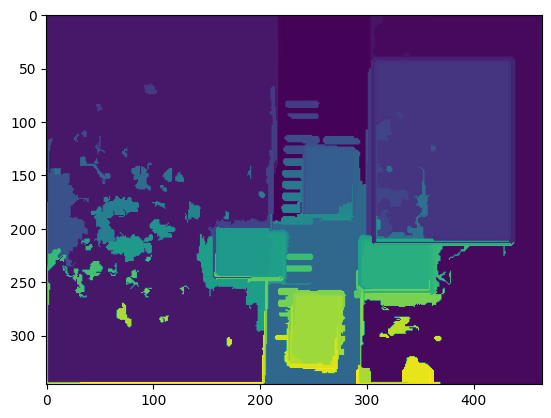

In [86]:
segments_fz = felzenszwalb(img, scale=200)
plt.imshow(segments_fz)

In [84]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img,scale=20,min_size=10)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
        return candidates

2025-02-24 23:20:49,731 - INFO - x=306;y=42;w=129;h=171


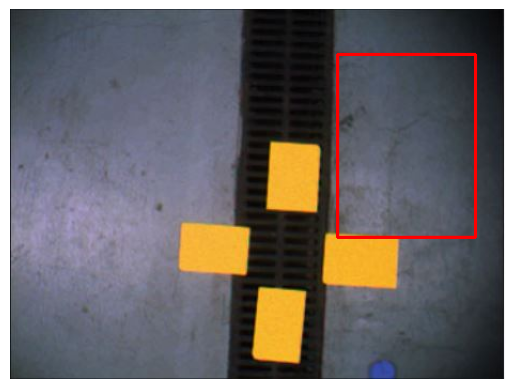

In [85]:
candidates = extract_candidates(img)
len(candidates)
for candidate in candidates:
    x , y , w , h = candidate
    logger.info(f'x={x};y={y};w={w};h={h}')
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)


plt.imshow(img)
plt.axis('off')
plt.show()

### In the following example please note that direction of vertical axis is downward, the deeper pixel the higher y coordinate

In [16]:
def calculate_iou(boxA,boxB,epsilion = 1e-5):
    logger.info(boxA)
    logger.info(boxB)
    # boxA and boxB are in the format (x1, y1, x2, y2)
    # where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    # Compute the area of both boxes
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the area of union
    union_area = boxA_area + boxB_area - inter_area

    # Compute the IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

In [2]:
boxA = (1,3,3,1)
boxB = (2,4,4,2)

intersection = calculate_iou(boxA,boxB)
logger.info(intersection)

NameError: name 'logger' is not defined

In [102]:
import selectivesearch
from torch import cuda,optim
import cv2
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
from torchvision.ops import nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd,numpy as np
import torchsummary
from torch import nn
from pathlib import Path
from pandas import DataFrame as df
device = 'cuda' if cuda.is_available() else 'cpu'
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

2025-03-22 13:29:31,247 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [103]:
IMAGE_FOLDER = './data/open-images-bus-trucks/open-images-bus-trucks/images'

class OpenImages(Dataset):
    def __init__(self,df,image_folder=IMAGE_FOLDER):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_path = f'{self.root}/{image_id}.jpg'
        #READ IMAGE AND CONVERT IT TO RGB
        image = cv2.imread(image_path)[...,::-1]
        h,w,_ = image.shape
        image_df = df[df['ImageID']==image_id]
        boxes = image_df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = image_df['LabelName'].values.tolist()
        return image,boxes,classes,image_path

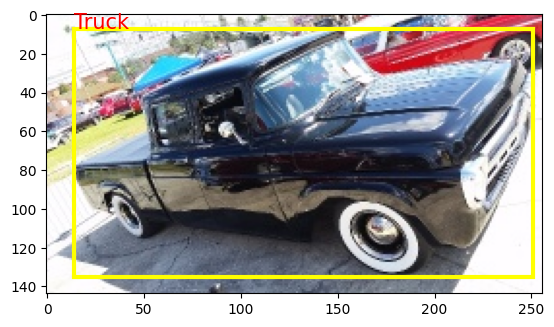

In [104]:
df = pd.read_csv('./data/open-images-bus-trucks/open-images-bus-trucks/df.csv')
ds = OpenImages(df)
image,boxes,classes,_ = ds[5]
fig,ax = plt.subplots()
ax.imshow(image)
for box in boxes:
    bottom_left = box[0],box[1]
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]
    rectangle = patches.Rectangle(
        bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
        facecolor='none'
        )
    ax.add_patch(rectangle)
    text_x = box[0] 
    text_y = box[1] 
    ax.text(text_x,text_y ,classes[0],color='red',fontsize=15)
plt.show()

In [105]:
def extract_candidates(img):
    img_lbl,regions = selectivesearch.selective_search(img,scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [106]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

In [107]:
N = 250
for ix, (im,bbx,labels,fpath) in enumerate(ds):
    if ix==N:
        break
    W,H,_ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h )for  x,y,w, h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate,__bb__,0.5) for candidate in candidates] \
                     for __bb__ in bbx]).T
    
    for jx,candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate

        # which should be a vector with columns that represent bounding boxes
        candidate_ious = ious[jx] 

        # for each candidate find the nearest related bounded box
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        logger.info(best_iou)
        best_bounding_box = x,y,X,Y = bbx[best_iou_at]
        clss.append(labels[best_iou_at])  if best_iou > .3 else clss.append('background')
        deltas.append( [cx - x, cy - y, cX - X, cY- Y] / np.array([W,H,W,H]))

        rois.append(candidate / np.array([W,H,W,H]))
    

    FPATHS.append(fpath)
    GTBBS.append(bbx)
    CLSS.append(clss)
    DELTAS.append(deltas) 
    ROIS.append(rois)
    IOUS.append(ious)

c:\Python39\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
2025-03-22 13:29:36,690 - INFO - 0.28067895719970765
c:\Python39\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
2025-03-22 13:29:37,156 - INFO - 0.1253031058927266
c:\Python39\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this fun

In [108]:
FPATHS = [f'{IMAGE_FOLDER}/{Path(f).stem}.jpg' for f in FPATHS]

#WHY? for transforming into dataframe
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]
flattened_class = [item for one_d_list in CLSS for item in one_d_list]
targets = pd.DataFrame(flattened_class,columns=['label'])
label2target =  {label:ix for ix,label in enumerate(targets['label'].unique())}

logger.info(label2target)
targets2label = { ix:label for label,ix in label2target.items() }
background_class = label2target['background']

2025-03-22 13:33:51,040 - INFO - {'background': 0, 'Bus': 1, 'Truck': 2}


In [109]:
normalize = transforms.Normalize(mean=[.432,.436,.433],std=[.232,.214,.216])


def process_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

In [110]:
def decode(y):
    _,preds = y.max(-1)
    return preds

In [82]:
len(ROIS[5])

1

In [15]:
class RCNNDataset(Dataset):
    def __init__(self,fpaths,rois,labels,delats,gtbbs):
        self.fpaths = fpaths
        self.rois = rois
        self.labels = labels
        self.delats = delats
        self.gtbbs = gtbbs
    def __len__(self):return len(self.fpaths)
    def __getitem__(self, index):
        image_path = self.fpaths[index]
        image = cv2.imread(image_path)[...,::-1]
        gtbbs = self.gtbbs[index] 
        deltas = self.delats[index]
        labels = self.labels[index]
        roi = self.rois[index]
        W,H,_ = image.shape
        sh = [W,H,W,H]
        bbs = (roi * np.array(sh)).astype(np.uint16)
        
        corps = [ image[x:X,y:Y] for x,y,X,Y in bbs ]
        return image_path,image,corps,bbs,labels,deltas,gtbbs


    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas =[],[],[],[],[]
        for ix in range(len(batch)):
            image_fpath,image, crops, image_bbs, image_labels, \
                image_deltas, image_gt_bbs, \
                 = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [process_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
            input = torch.cat(input).to(device)
            labels = torch.Tensor(labels).long().to(device)
            deltas = torch.Tensor(deltas).float().to(device)
            return input, labels, deltas

In [16]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train],ROIS[:n_train],CLSS[:n_train], DELTAS[:n_train],GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:],CLSS[n_train:], DELTAS[n_train:],GTBBS[n_train:])
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2,collate_fn=test_ds.collate_fn,drop_last=True)

In [17]:
vgg_backbone = models.vgg16(weights=models.VGG16_Weights)
vgg_backbone.classifier = torch.nn.Sequential()
for parameter in vgg_backbone.parameters():
    parameter.requires_grad = False

vgg_backbone.eval().to(device)


c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
torchsummary.summary(vgg_backbone, torch.zeros([3,254,254]))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 7, 7]                --
|    └─Conv2d: 2-1                       [-1, 254, 254]            (1,792)
|    └─ReLU: 2-2                         [-1, 254, 254]            --
|    └─Conv2d: 2-3                       [-1, 254, 254]            (36,928)
|    └─ReLU: 2-4                         [-1, 254, 254]            --
|    └─MaxPool2d: 2-5                    [-1, 127, 127]            --
|    └─Conv2d: 2-6                       [-1, 127, 127]            (73,856)
|    └─ReLU: 2-7                         [-1, 127, 127]            --
|    └─Conv2d: 2-8                       [-1, 127, 127]            (147,584)
|    └─ReLU: 2-9                         [-1, 127, 127]            --
|    └─MaxPool2d: 2-10                   [-1, 63, 63]              --
|    └─Conv2d: 2-11                      [-1, 63, 63]              (295,168)
|    └─ReLU: 2-12                        [-1, 63, 63] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 7, 7]                --
|    └─Conv2d: 2-1                       [-1, 254, 254]            (1,792)
|    └─ReLU: 2-2                         [-1, 254, 254]            --
|    └─Conv2d: 2-3                       [-1, 254, 254]            (36,928)
|    └─ReLU: 2-4                         [-1, 254, 254]            --
|    └─MaxPool2d: 2-5                    [-1, 127, 127]            --
|    └─Conv2d: 2-6                       [-1, 127, 127]            (73,856)
|    └─ReLU: 2-7                         [-1, 127, 127]            --
|    └─Conv2d: 2-8                       [-1, 127, 127]            (147,584)
|    └─ReLU: 2-9                         [-1, 127, 127]            --
|    └─MaxPool2d: 2-10                   [-1, 63, 63]              --
|    └─Conv2d: 2-11                      [-1, 63, 63]              (295,168)
|    └─ReLU: 2-12                        [-1, 63, 63] 

In [ ]:
class RCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = vgg_backbone
        feature_dim = 25088
        self.cls_score = torch.nn.Linear(feature_dim,len(targets2label))
        self.bbox = torch.nn.Sequential(
                torch.nn.Linear(feature_dim,512),
                torch.nn.ReLU(),
                torch.nn.Linear(512,4),
                torch.nn.Tanh()
            )
        self.cel = nn.CrossEntropyLoss()
        self.l1l = nn.L1Loss()
    def forward(self,input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score,bbox

    def calc_loss(self,_deltas,probs,delats,labels):
        detection_loss = self.cel(probs,labels)
        ix,=torch.where(labels != 0)
        self.lmb = 10
        if len(ix) > 0:
            regression_loss = self.l1l(_deltas,delats)
            return detection_loss + regression_loss * self.lmb,\
                    detection_loss.detach(),regression_loss.detach()
        
        else:
            regression_loss = 0
            return detection_loss + self.lmb*regression_loss, \
                detection_loss.detach(), regression_loss

In [122]:
def train_batch(input,model,optimizer,criterion):
    input, label, deltas = input
    model.train()
    optimizer.zero_grad()
    _class,_delta = model(input)
    loss,detection_loss,reg_loss = criterion(_delta,_class,deltas,label)
    accs = label == decode(_class)
    loss.backward()
    optimizer.step()
    return loss.detach(),detection_loss,reg_loss,accs.cpu().numpy()


@torch.no_grad()
def validate_batch(inputs,model,criterion):
    input,labels,deltas = inputs
    with torch.no_grad():
        model.eval()
    _clss,_delta = model(input)
    loss,detection_loss,reg_loss = criterion(_delta,_clss,deltas,labels)
    accs = labels == decode(_clss)
    return loss.detach(),detection_loss,reg_loss,accs.cpu().numpy()

In [132]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 4
train_epoch_accs ,test_epoch_accs,train_epoch_loss,test_epoch_loss = [],[],[],[]
for ex in range(n_epochs):
    N = len(train_loader)
    train_losses, train_accs = [],[]
    for bx, data in enumerate(train_loader):
        loss, detection_loss,reg_loss, acc = train_batch(data,rcnn, optimizer, criterion)
        train_accs.append(acc)
        train_losses.append(loss)
        logger.debug(f'train loss = {loss},train accuracy is {acc}')
    
    train_epoch_accs.append(np.mean(train_accs))
    train_epoch_loss.append(np.mean(train_losses))
    N = len(test_loader)
    test_losses, test_accs = [],[]
    for bx, data in enumerate(test_loader):
        loss, detection_loss,reg_loss, acc = validate_batch(data,rcnn, criterion)
        test_accs.append(acc)
        test_losses.append(loss)
        logger.debug(f'val loss = {loss},val accuracy is {acc}')

        
    test_epoch_accs.append(np.mean(test_accs))
    test_epoch_loss.append(np.mean(test_losses))

2025-03-21 02:37:19,226 - INFO - labels is tensor([0])
2025-03-21 02:37:19,229 - INFO - probs is tensor([[ 0.1833, -0.3169, -0.3765]], grad_fn=<AddmmBackward0>)
2025-03-21 02:37:19,232 - INFO - cel CrossEntropyLoss()
2025-03-21 02:37:19,234 - INFO - type of detection loss is <class 'torch.Tensor'>
2025-03-21 02:37:19,241 - DEBUG - train loss = 0.7782498002052307,train accuracy is [ True]
2025-03-21 02:37:19,760 - INFO - labels is tensor([0])
2025-03-21 02:37:19,763 - INFO - probs is tensor([[ 1.9422, -1.9984, -1.6096]], grad_fn=<AddmmBackward0>)
2025-03-21 02:37:19,766 - INFO - cel CrossEntropyLoss()
2025-03-21 02:37:19,767 - INFO - type of detection loss is <class 'torch.Tensor'>
2025-03-21 02:37:19,767 - DEBUG - train loss = 0.04698707163333893,train accuracy is [ True]
2025-03-21 02:37:20,252 - INFO - labels is tensor([2])
2025-03-21 02:37:20,252 - INFO - probs is tensor([[ 2.8981, -1.1815, -1.0195]], grad_fn=<AddmmBackward0>)
2025-03-21 02:37:20,252 - INFO - cel CrossEntropyLoss()


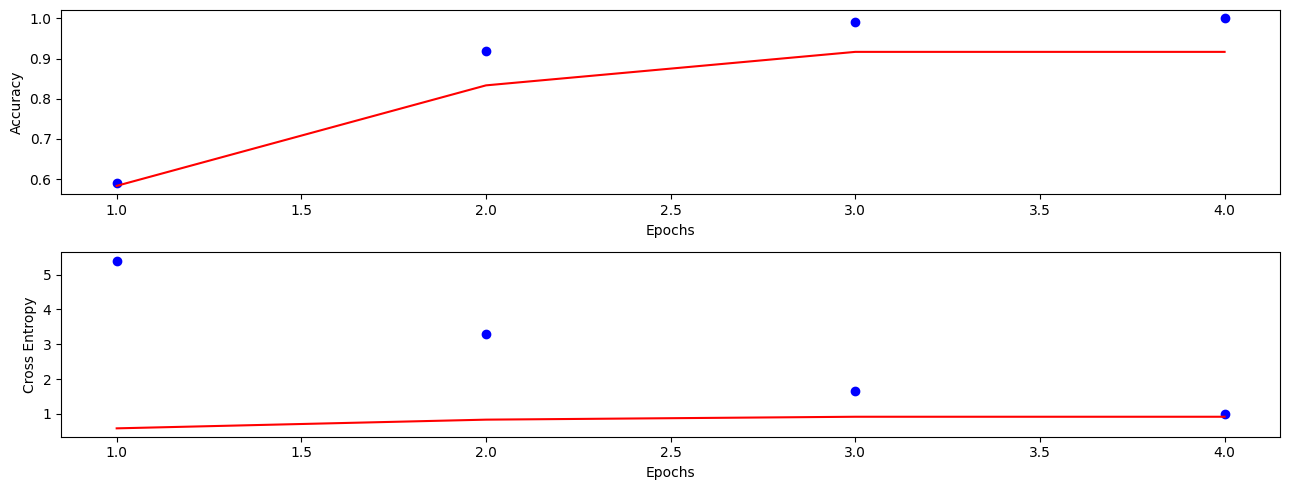

In [133]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(2,1,figsize=(13,5))
ax = ax.flat

ax[0].plot(epochs, train_epoch_accs, 'bo')
ax[0].plot(epochs, test_epoch_accs, 'r')



ax[1].plot(epochs, train_epoch_loss, 'bo')
ax[1].plot(epochs, test_epoch_accs, 'r')


ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('Cross Entropy')

fig.tight_layout()
plt.show()

In [158]:
def show(ax,img,title):
    ax.set_title(title)
    ax.imshow(img)

def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(process_image(crop/255.)[None])
        input = torch.cat(input).to(device)

        with torch.no_grad():
            rcnn.eval()
            probs, deltas = rcnn(input)
            probs = torch.nn.functional.softmax(probs, -1)
            confs, clss = torch.max(probs, -1)
            logger.info(f'predicted class {targets2label[clss.item()]}')

        candidates = np.array(candidates)
        confs,clss,probs,deltas=[tensor.detach().cpu().numpy() \
        for tensor in [confs, clss, probs, deltas]]
        ixs = clss!=background_class
        logger.info(f'ixs is {ixs}')
        confs,clss,probs,deltas,candidates = [tensor[ixs] for \
        tensor in [confs,clss, probs, deltas,candidates]]
        bbs = (candidates + deltas).astype(np.uint16)
        ixs = nms(torch.tensor(bbs.astype(np.float32)),torch.tensor(confs), 0.05)
        if len(ixs) == 1:
            confs, clss, probs, deltas, candidates, bbs = \
                    [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
            logger.info(confs)
        if len(confs) == 0 and not show_output:
            return (0,0,224,224), 'background', 0
        if len(confs) > 0:
            best_pred = np.argmax(confs)
            best_conf = np.max(confs)
            best_bb = bbs[best_pred].squeeze()
            logger.info(best_bb)
            x,y,X,Y = best_bb

        _, ax = plt.subplots(1, 2, figsize=(20,10))
        show(ax[0],img,'Original image')
        if len(confs) == 0:
            ax[1].set_title('No objects')
            ax[1].imshow(img)
            return
        logger.info(f'best pred which is going to be as title {type(clss[best_pred].item())}')
        for box in boxes:
            bottom_left = box[0],box[1]
            box_width = box[2] - box[0]
            box_height = box[3] - box[1]
            rectangle = patches.Rectangle(
                bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
                facecolor='none'
                )
            ax[1].add_patch(rectangle)
        show(ax[1],img,targets2label[clss[best_pred].item()])
        return (x,y,X,Y),targets2label[clss[best_pred].item()],best_conf


2025-03-21 02:52:16,018 - INFO - predicted class background
2025-03-21 02:52:16,018 - INFO - ixs is [False]


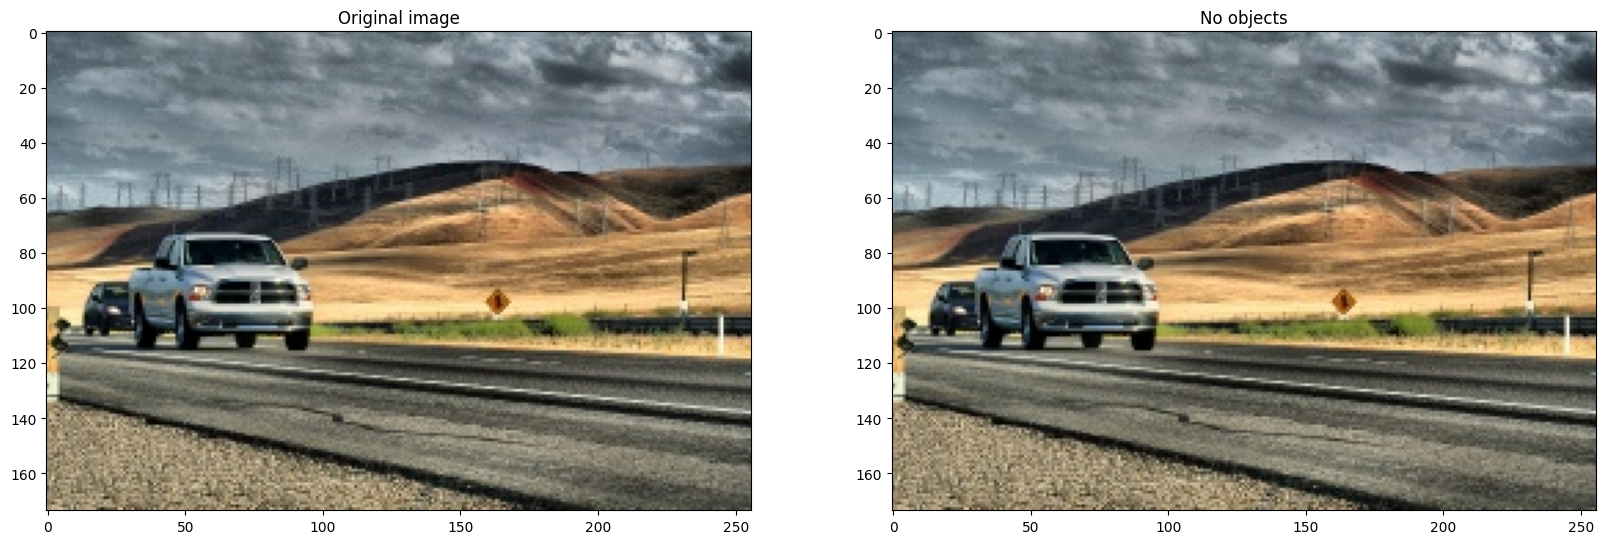

In [159]:
fpath,image, crops, bbs, labels, deltas, gtbbs = test_ds[14]

test_predictions(fpath)

## Fast RCN Neural Networks

In [70]:
import selectivesearch
from torch import cuda,optim
import cv2
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
from torchvision.ops import RoIPool
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd,numpy as np
import torchsummary
from torch import nn
from pathlib import Path
from pandas import DataFrame as df
device = 'cuda' if cuda.is_available() else 'cpu'
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

2025-03-22 13:21:07,582 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [111]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        logger.info(f'rois s ={rois}\nlabels is {labels}\ndeltas is :{deltas}')
        assert len(rois) == len(labels) == len(deltas), \
        f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [],[],[],[],[]
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, \
            image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(process_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [112]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train],ROIS[:n_train],CLSS[:n_train], DELTAS[:n_train],GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:],CLSS[n_train:], DELTAS[n_train:],GTBBS[n_train:])
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2,collate_fn=test_ds.collate_fn,drop_last=True)

In [113]:
train_ds.deltas[5]

[array([-0.09722222, -0.02734375,  0.02777778,  0.03125   ])]

In [114]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet= models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = False

        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh(),
        )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1) #what the heg?
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox=self.bbox(feat)#.view(-1,len(label2target),4)
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, \
            detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, \
            detection_loss.detach(), regression_loss

In [118]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss =criterion(_clss,_deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss,regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return loss.detach(),loc_loss,regr_loss, accs.cpu().numpy()

In [119]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)
n_epochs = 4
train_epoch_accs ,test_epoch_accs,train_epoch_loss,test_epoch_loss = [],[],[],[]
for ex in range(n_epochs):
    N = len(train_loader)
    train_losses, train_accs = [],[]
    for bx, data in enumerate(train_loader):
        loss, detection_loss,reg_loss, acc = train_batch(data,frcnn, optimizer, criterion)
        train_accs.append(acc)
        train_losses.append(loss)
        logger.debug(f'train loss = {loss},train accuracy is {acc}')
    
    train_epoch_accs.append(np.mean(train_accs))
    train_epoch_loss.append(np.mean(train_losses))
    N = len(test_loader)
    test_losses, test_accs = [],[]
    for bx, data in enumerate(test_loader):
        loss, detection_loss,reg_loss, acc = validate_batch(data,frcnn, criterion)
        test_accs.append(acc)
        test_losses.append(loss)
        logger.debug(f'val loss = {loss},val accuracy is {acc}')

        
    test_epoch_accs.append(np.mean(test_accs))
    test_epoch_loss.append(np.mean(test_losses))

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025-03-22 14:35:41,558 - INFO - rois s =[array([0.        , 0.        , 1.5       , 0.66015625])]
labels is ['background']
deltas is :[array([-0.51764706, -0.1015625 ,  0.13529412,  0.23046875])]
2025-03-22 14:35:41,660 - INFO - rois s =[array([0.        , 0.        , 1.5       , 0.66015625])]
labels is ['background']
deltas is :[array([-0.41176471, -0.09375   ,  0.45294118,  0.37109375])]
202

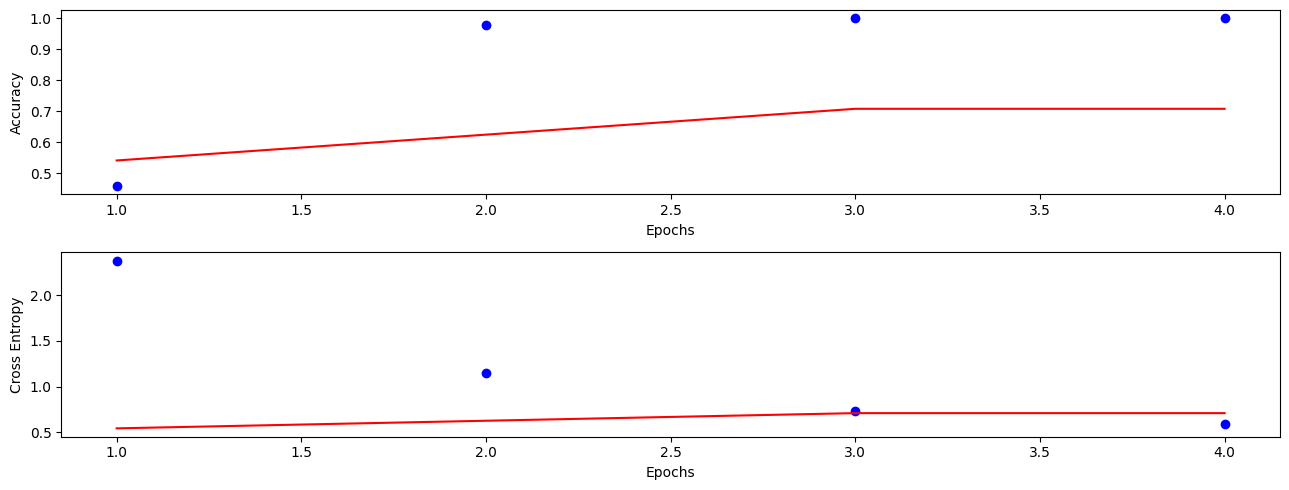

In [120]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(2,1,figsize=(13,5))
ax = ax.flat

ax[0].plot(epochs, train_epoch_accs, 'bo')
ax[0].plot(epochs, test_epoch_accs, 'r')



ax[1].plot(epochs, train_epoch_loss, 'bo')
ax[1].plot(epochs, test_epoch_accs, 'r')


ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('Cross Entropy')

fig.tight_layout()
plt.show()

In [194]:
from PIL import Image
def show(ax,img,title,original_size):
    ax.set_title(title)
    ax.imshow(cv2.resize(img,original_size))

def test_predictions(filename,gtbbs ,show_output=True):
    img = np.array(Image.open(filename))
    img_original_size = img.shape[1],img.shape[0]
    logger.info(f'image size is {img_original_size}')
    img = cv2.resize(img, (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = process_image(torch.tensor(img).float())[None]

    rois = [[x/224 ,y/224 ,X/224 ,Y/224 ]for x,y,X,Y in candidates]
    ridx = np.array([0]*len(rois))
    rois , ridx = [torch.tensor(item) for item in (rois,ridx)]
    logger.info(rois)
    logger.info(ridx)
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input,rois,ridx)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
        logger.info(f'predicted class {targets2label[clss.item()]}')

    candidates = np.array(candidates)
    confs,clss,probs,deltas=[tensor.detach().cpu().numpy() \
    for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class
    logger.info(f'ixs is {ixs}')
    confs,clss,probs,deltas,candidates = [tensor[ixs] for \
    tensor in [confs,clss, probs, deltas,candidates]]
    bbs = (candidates + deltas).astype(np.float32)
    ixs = nms(torch.tensor(bbs.astype(np.float32)),torch.tensor(confs), 0.05)
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = \
                [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
        logger.info(confs)
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred].squeeze()
        logger.info(best_bb)
        x,y,X,Y = best_bb

    _, ax = plt.subplots(1, 2, figsize=(20,10))
    for box in gtbbs:
        bottom_left = box[0],box[1]
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]
        rectangle = patches.Rectangle(
            bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
            facecolor='none'
            )
        ax[0].add_patch(rectangle)
    show(ax[0],img,'Original image',img_original_size)
    if len(confs) == 0:
        ax[1].set_title('No objects')
        ax[1].imshow(img)
        return
    logger.info(f'best pred which is going to be as title {type(clss[best_pred].item())}')
    for box in boxes:
        bottom_left = box[0],box[1]
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]
        rectangle = patches.Rectangle(
            bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
            facecolor='none'
            )
        ax[1].add_patch(rectangle)
    show(ax[1],img,targets2label[clss[best_pred].item()],img_original_size)
    return (x,y,X,Y),targets2label[clss[best_pred].item()],best_conf


2025-03-22 15:35:29,913 - INFO - rois s =[array([0.        , 0.        , 1.46551724, 0.67578125])]
labels is ['background']
deltas is :[array([-0.16666667, -0.26953125,  0.90229885,  0.22265625])]
2025-03-22 15:35:29,918 - INFO - image size is (256, 174)
c:\Python39\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\MASOUD\AppData\Local\Temp\ipykernel_15984\610567506.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).permute(2,0,1)
2025-03-22 15:35:30,549 - INFO - tensor([[0.0000, 0.0000, 0.9955, 0.9955]])
2025-03-22 15:35:30,554 - INFO - tensor([0], dtyp

((0.878831, -1.0, 222.55443, 224.0), 'Bus', 1.0)

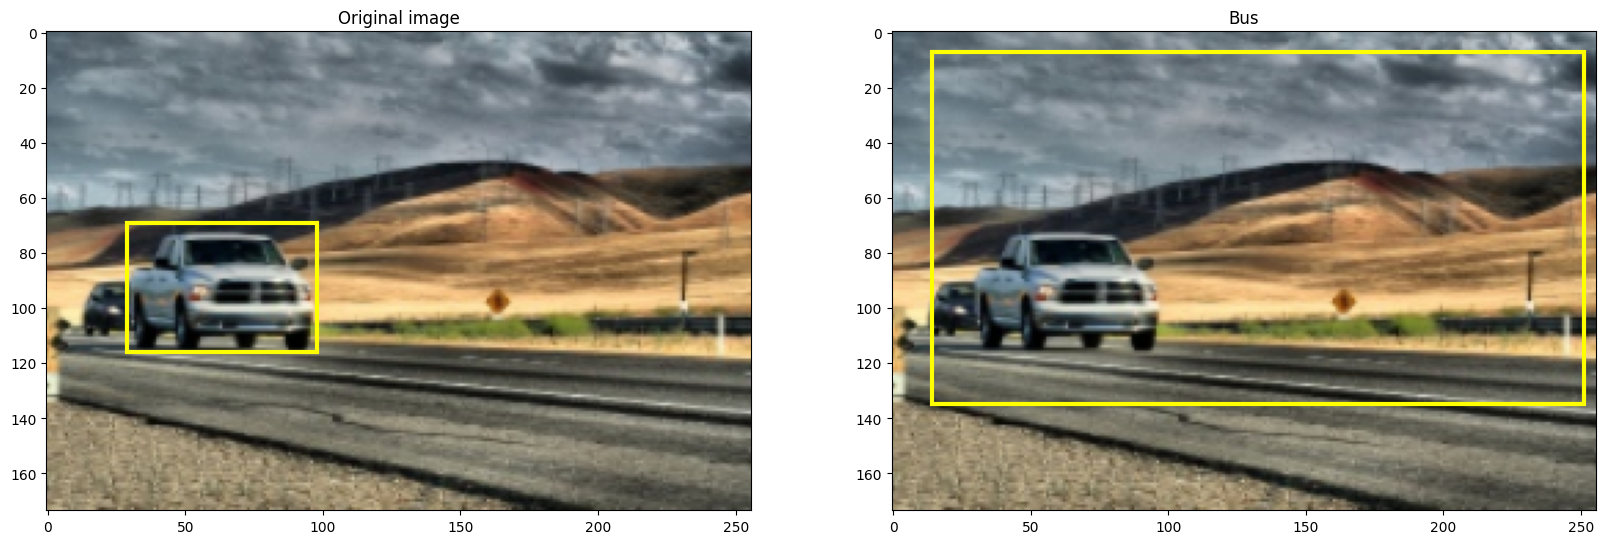

In [195]:
image, rois, labels, deltas, gtbbs, fpath = test_ds[14]

test_predictions(fpath,gtbbs)

2025-03-22 15:26:52,027 - INFO - rois s =[array([0.        , 0.        , 1.46551724, 0.67578125])]
labels is ['background']
deltas is :[array([-0.16666667, -0.26953125,  0.90229885,  0.22265625])]


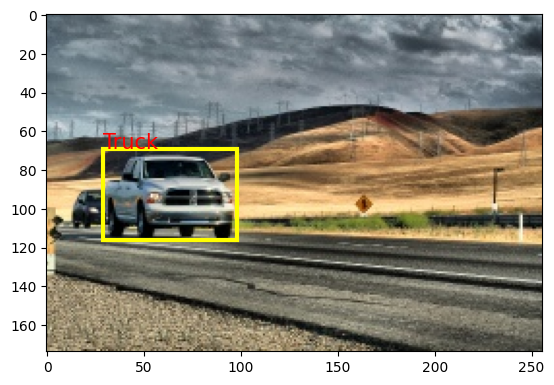

In [ ]:
image, rois, labels, deltas, gtbbs, fpath = test_ds[14]
fig,ax = plt.subplots()
ax.imshow(image)
for box in gtbbs:
    bottom_left = box[0],box[1]
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]
    rectangle = patches.Rectangle(
        bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
        facecolor='none'
        )
    ax.add_patch(rectangle)
    text_x = box[0] 
    text_y = box[1] 
    ax.text(text_x,text_y ,classes[0],color='red',fontsize=15)
plt.show()